### Modelling the Galactic LMXB distribution

In [195]:
import os
from multiprocessing import Pool

import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.integrate as integrate
import astropy.units as u
import astropy.coordinates as coord 
import healpy as hp
%matplotlib notebook

We follow https://ui.adsabs.harvard.edu/abs/2019MNRAS.484...19J and use https://ui.adsabs.harvard.edu/abs/2002A%26A...391..923G/abstract to construct a function which provides probabilistic samples of LMXB positions and distances.  Grimm+02 has a typo for the disk distribution; we use the correct version from https://ui.adsabs.harvard.edu/abs/1998MNRAS.294..429D/abstract.

In [2]:
density_convert = (1*u.parsec**-3).to(u.kpc**-3.)

In [3]:
def rho_bulge(r, z, rho0_bulge=1.9789*1e9, r0=1.0, q=0.6, gamma=1.8, rt=1.9):
    """Bulge density model from Grimm et al. 2002 (Eqn. 4)
    
    Parameters
    ----------
    r : float
        distance from the Galactic center (kpc)
    z : float
        distance perpendicular to the Galactic Plane (kpc)
    
    Returns
    -------
    density in solar masses per cubic kpc
    
    """
    
    return rho0_bulge * (np.sqrt(r**2. + z**2./q**2.)/r0)**(-1.*gamma) * np.exp(-1. * (r**2. + z**2./q**2.)/rt**2.)

def rho_disk(r, z, rho0_disk=1.313415*1e9, rm=6.5, rd=3.5, rz=0.410):
    """Disk density model from Grimm et al. 2002 (Eqn. 5).  
    
    Note a typo in the Grimm+02 paper; we include the correct version from Dehnen & Binney (1998)
    
    Parameters
    ----------
    r : float
        distance from the Galactic center (kpc)
    z : float
        distance perpendicular to the Galactic Plane (kpc)
    
    Returns
    -------
    density in solar masses per cubic kpc
    
    """
    
    return rho0_disk * np.exp(-1.*rm/rd - r/rd - np.abs(z)/rz)

def mass_disk(rho0_disk=1.313415*1e9, rm=6.5, rd=3.5, rz=0.410):
    """Integrated mass of disk from Dehnen & Binney (1998) eqn. 2
    
    Parameters
    ----------
    
    Returns
    -------
    density in solar masses
    
    """
    from scipy.special import kn
    
    sigma_d = rho0_disk * 2 * rz
    
    return 4*np.pi*sigma_d*rm*rd* kn(2,2*np.sqrt(rm/rd))

def rho_sphere(r, z, rho0_sphere=8.74*1e9, b=7.669, Re=2.8):
    """Disk density model from Grimm et al. 2002 (Eqn. 6)
    
    Parameters
    ----------
    r : float
        distance from the Galactic center (kpc)
    z : float
        distance perpendicular to the Galactic Plane (kpc)
    
    Returns
    -------
    density in solar masses per cubic kpc
    
    """
    
    R = np.sqrt(r**2. + z**2.)
    
    return rho0_sphere * np.exp(-1.*b*(R/Re)**(1/4)) / (R/Re)**(7/8)

Integrate numerically to get total masses.  Integrate in Galactocentric cylindrical coordinates from r ∊ 0,15 kpc, z ∊ -15,15 kpc

In [4]:
bulge_mass = 2*np.pi*integrate.dblquad(lambda r,z: r * rho_bulge(r,z), -15, 15, lambda r: 0, lambda r: 15)[0] 
disk_mass = 2*np.pi*integrate.dblquad(lambda r,z: r * rho_disk(r,z), -15, 15, lambda r: 0, lambda r: 15)[0]  
sphere_mass = 2*np.pi*integrate.dblquad(lambda r, z: r * rho_sphere(r,z), -15, 15, lambda r: 0, lambda r: 15)[0]  

Compare our numerical integral to the analytic value... not perfect

In [5]:
mass_disk()/disk_mass

2.2802363085057036

MJ reports that they could not reproduce the Grimm mass ratios with the provided normalizations.  We will follow them and use the [Picaurd & Robin 04](https://ui.adsabs.harvard.edu/abs/2004A%26A...428..891P/abstract) bulge mass estimate of 2.4e10 Msun, and adjust the other normalizations to match ratios of 2:1:0.3.

In [6]:
print(f'{bulge_mass:.2e} {disk_mass:.2e} {sphere_mass:.2e}')

2.40e+10 1.20e+10 3.60e+09


In [7]:
bulge_mass/disk_mass

1.9999954308634986

In [8]:
sphere_mass/disk_mass

0.2998325450823631

## load 3-d extinction maps and test them

we will use a fork of https://github.com/willclarkson/rubinCadenceScratchWIC

In [9]:
import sys
sys.path.append('../python')
import readExtinction

In [10]:
%load_ext autoreload
%autoreload 2

In [11]:
pathReddening = '../data/merged_ebv3d_nside64.fits'
print(pathReddening, os.access(pathReddening, os.R_OK))

../data/merged_ebv3d_nside64.fits True


In [12]:
ebv = readExtinction.ebv3d(pathReddening)
ebv.loadMap()

<IPython.core.display.Javascript object>


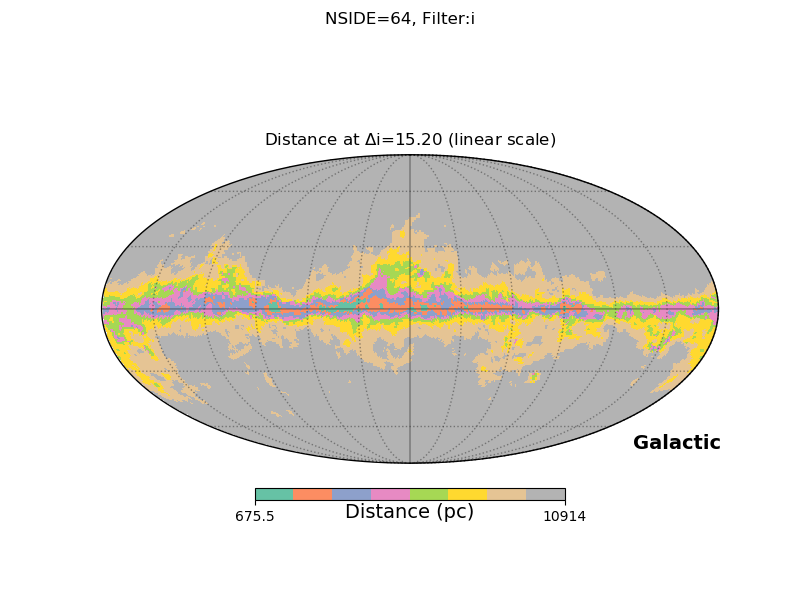

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


array([8585.23747277, 8483.37065217, 9058.13586957, ..., 9483.90305011,
       9412.00980392, 9273.67282609])

In [19]:
readExtinction.testDeltamags('i', 15.2, cmap='Set2', pathMap=pathReddening)

<IPython.core.display.Javascript object>


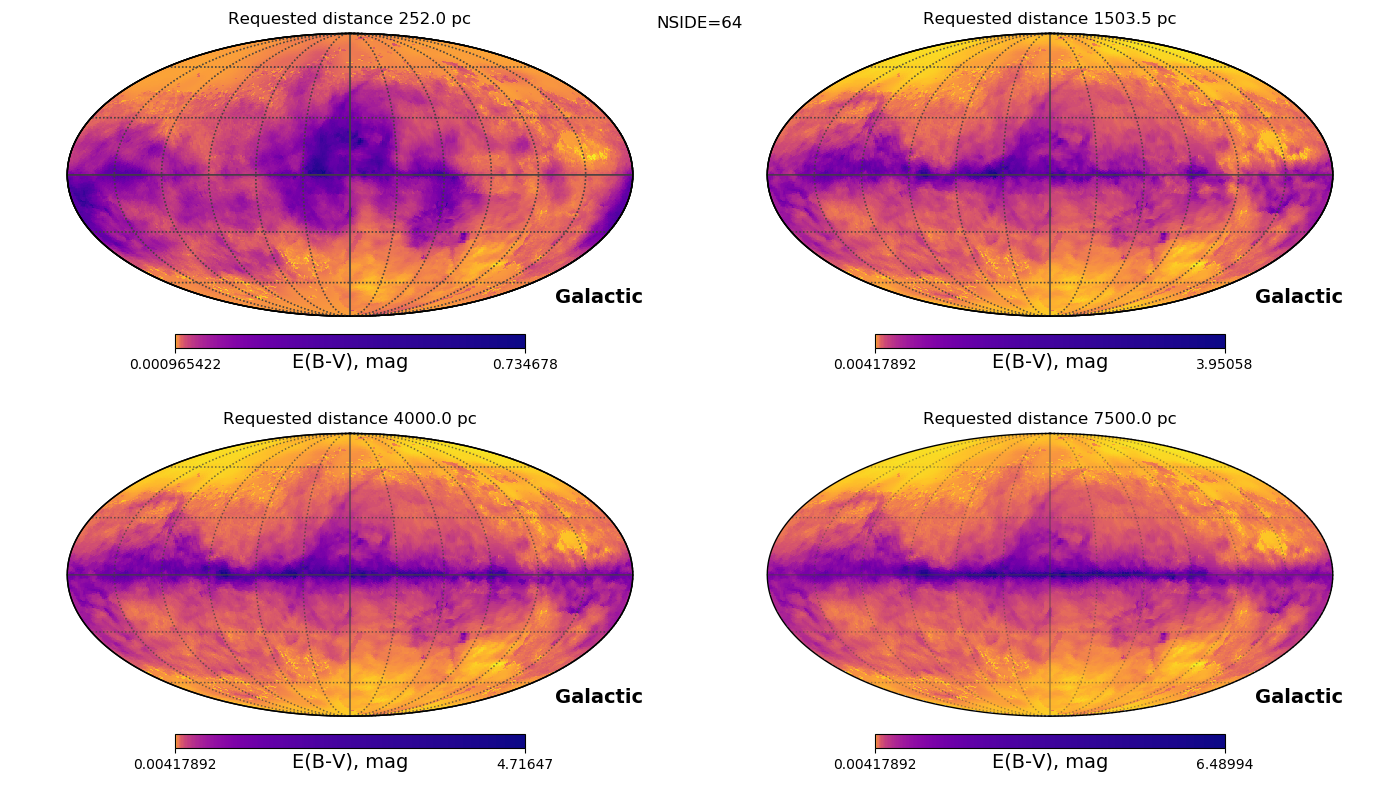

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The inter

In [20]:
readExtinction.testReadExt(False, pathMap=pathReddening)

In [21]:
dir(ebv)

['R_x',
 'Verbose',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'calcDistmods',
 'dists',
 'dmods',
 'ebvs',
 'getDeltaMag',
 'getDistanceAtMag',
 'getEBVatSightline',
 'getInterpolatedProfile',
 'getMapNearestDist',
 'getMaxDistDeltaMag',
 'hdr',
 'hpids',
 'loadMap',
 'mask',
 'nested',
 'nside',
 'pathMap',
 'sfacs',
 'showDistanceInterval',
 'showMollview']

<IPython.core.display.Javascript object>


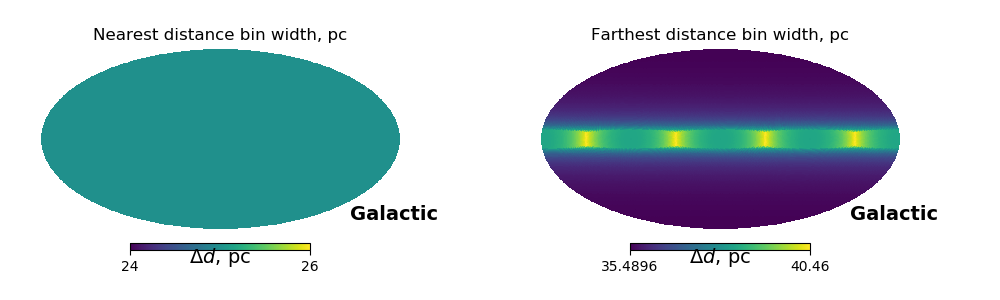

In [22]:
readExtinction.testShowDistresol( pathMap=pathReddening)

## determine distances to which we can see extincted K-stars.

We use the Johnson et al. 2019 absolute magnitudes for an LMXB with a K-type companion + disk in the LSST bands:

In [23]:
lmxb_abs_mag_r = 4.6
lmxb_abs_mags = {'u':lmxb_abs_mag_r + 4.14,
                 'g':lmxb_abs_mag_r + 3.24,
                 'r':lmxb_abs_mag_r,
                 'i':lmxb_abs_mag_r + 0.33,
                 'z':lmxb_abs_mag_r + 1.05,
                 'y':lmxb_abs_mag_r + 2.36
                 }

Next we load the limiting magnitudes per filter (taken from the Ivezic et al. 2019):

In [24]:
lsst_single_epoch_depth =  {'u':23.9,
                            'g':25.0,
                            'r':24.7,
                            'i':24.0,
                            'z':23.3,
                            'y':22.1
                            }

lsst_ten_year_depth =  {'u':26.1,
                        'g':27.4,
                        'r':27.5,
                        'i':26.8,
                        'z':26.1,
                        'y':24.9
                        }

The fiducial single-epoch depths are a compromise here: they are optimistic in the crowded regions of the Plane, but pessimistic when considering what can be achieved with forced photometry in data releases.  MAF has tools for assessing crowding but they are tied to specific OpSim runs in a way which is inconvenient for this purpose.

In [25]:
delta_mags = {}
for filt, M in lmxb_abs_mags.items():
    delta_mags[filt] = lsst_single_epoch_depth[filt] - M

In [26]:
delta_mags

{'u': 15.16,
 'g': 17.16,
 'r': 20.1,
 'i': 19.07,
 'z': 17.650000000000002,
 'y': 15.140000000000002}

<IPython.core.display.Javascript object>


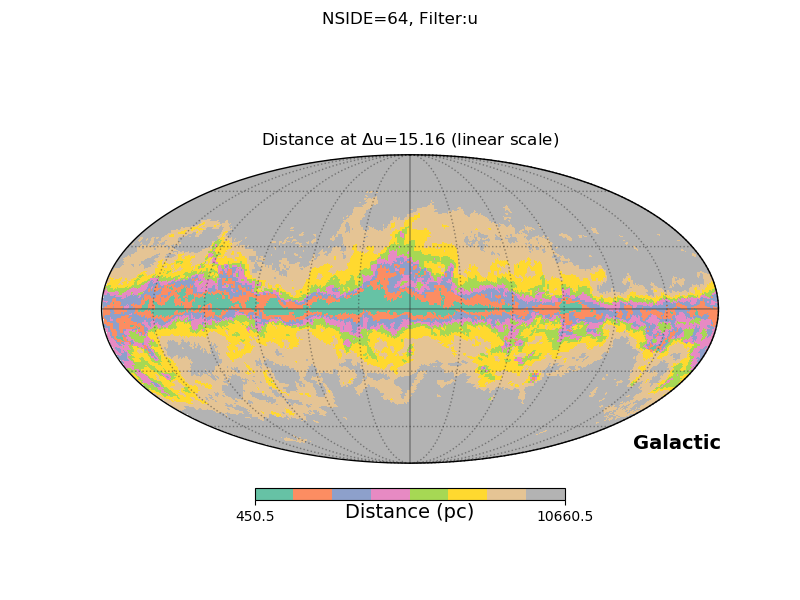

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


<IPython.core.display.Javascript object>


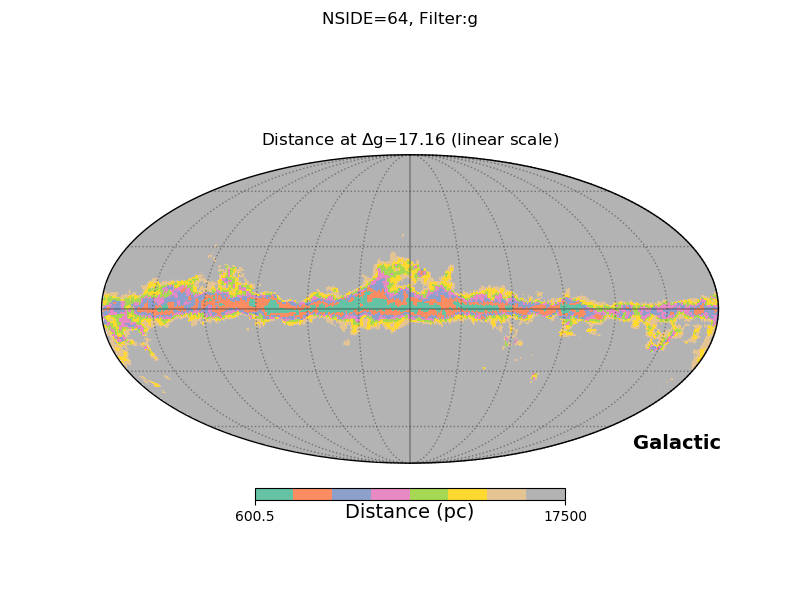

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


<IPython.core.display.Javascript object>


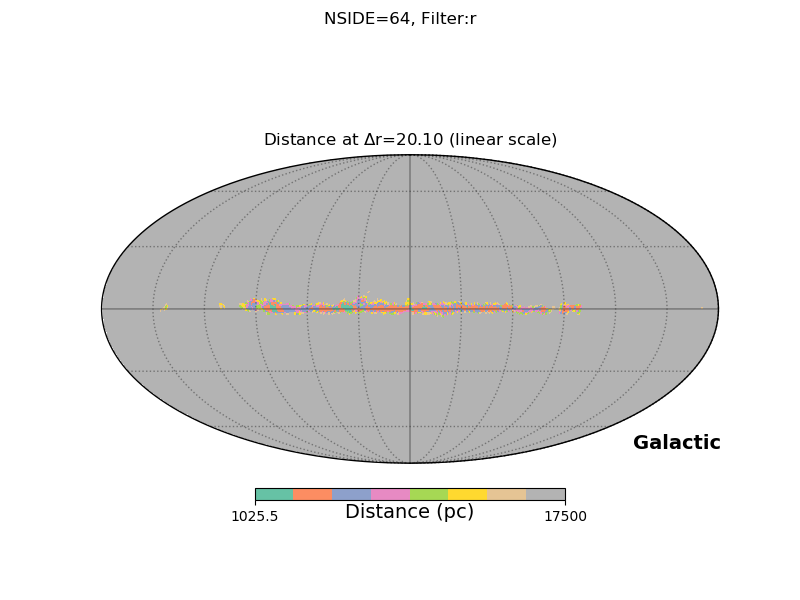

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


<IPython.core.display.Javascript object>


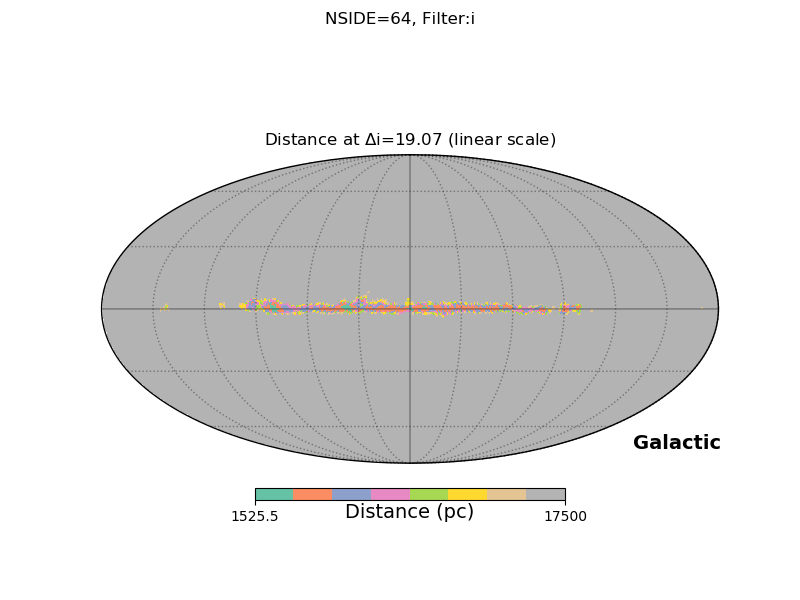

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


<IPython.core.display.Javascript object>


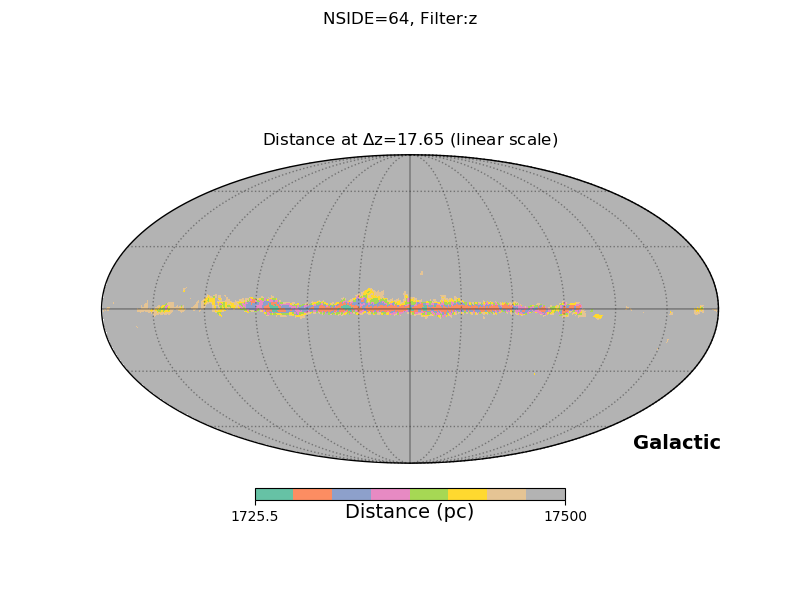

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


<IPython.core.display.Javascript object>


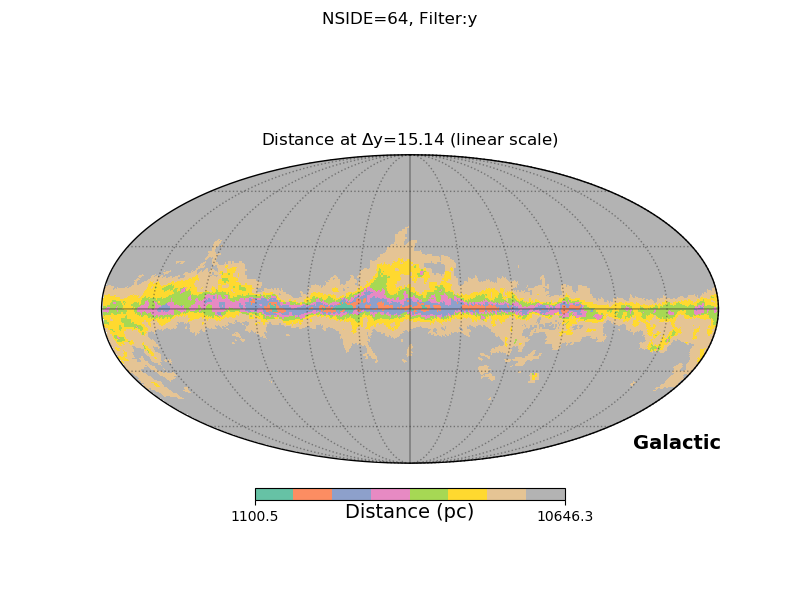

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


In [27]:
distance_to_deltamag = {}
for filt, dmag in delta_mags.items():
    distance_to_deltamag[filt] = readExtinction.testDeltamags(filt, dmag, cmap='Set2', pathMap=pathReddening)

In [28]:
distance_to_deltamag['u']

array([6068.97385621, 5932.85      , 6902.76630435, ..., 7650.62527233,
       7542.78540305, 7261.99456522])

## Convert to relative spatial density in l, b for the TVS Plane metric

We want to integrate our Galaxy model of stellar density from 0 to the max distance we can see K-dwarfs in LSST single-epoch images, due to extinction.

Ideally the nearby distance would be the saturation limit but I expect this is a relatively minor effect.

<IPython.core.display.Javascript object>


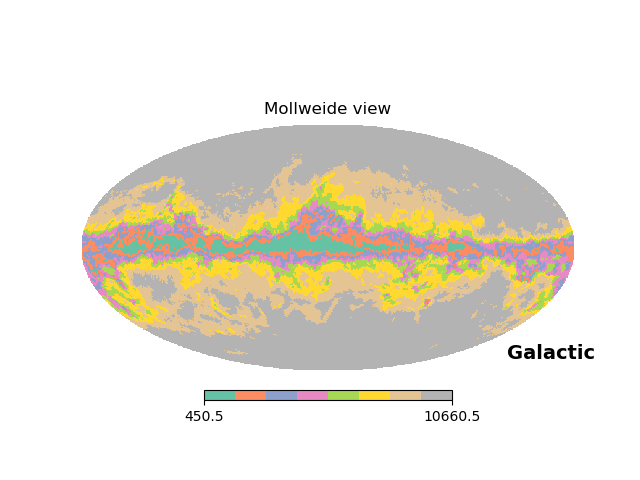

In [30]:
hp.mollview(distance_to_deltamag['u'], plt.figure(), coord=['C','G'],cmap='Set2',hold=True)

In [31]:
# get the coordinates of the healpix distance maps we've made
NSIDE=64
hp_ra, hp_dec = hp.pix2ang(NSIDE,np.arange(hp.nside2npix(NSIDE)),lonlat=True)

<IPython.core.display.Javascript object>


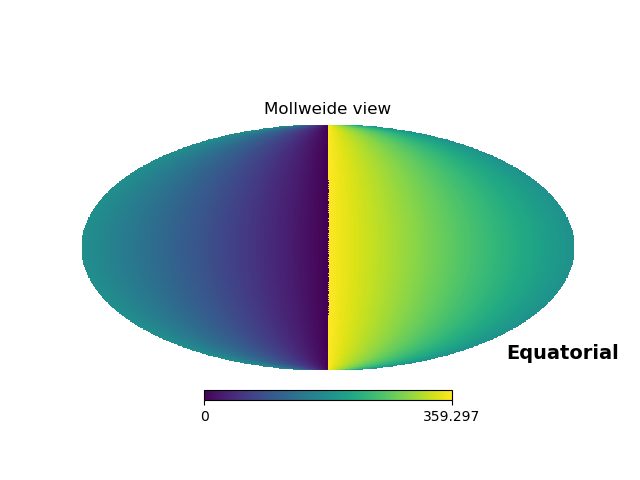

In [33]:
hp.mollview(hp_ra, plt.figure(), coord=['C'],hold=True)

<IPython.core.display.Javascript object>


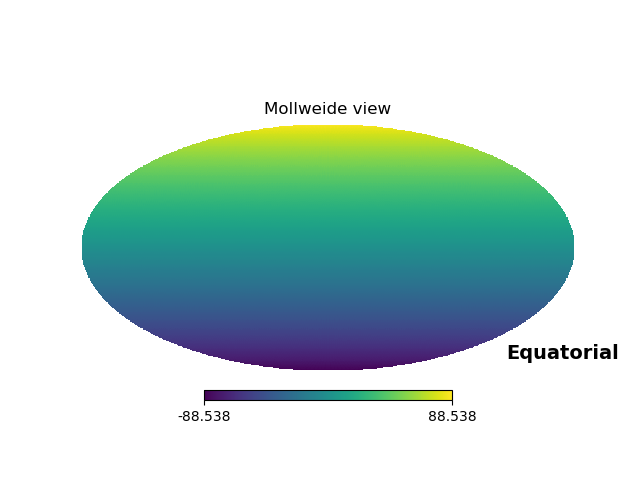

In [34]:
hp.mollview(hp_dec, plt.figure(), coord=['C'],hold=True)

In [47]:
def local_density(sc_in, distance_pc):
    
    # doing the coordinate conversion inside the integration loop is expensive...
    sc = coord.SkyCoord(sc_in.ra, sc_in.dec, distance_pc, frame='icrs', unit=('deg','deg','pc'))
    sc_gc = sc.transform_to(coord.Galactocentric)
    r = np.sqrt(sc_gc.x**2. + sc_gc.y**2.).to(u.kiloparsec).value
    z = (sc_gc.z).to(u.kiloparsec).value
    
    return rho_bulge(r,z) + rho_disk(r,z) + rho_sphere(r,z)

In [48]:
def integrate_density(sc,dmax,NSIDE=64):
    
    return integrate.quad(lambda d: d**2. * local_density(sc, d), 0, dmax)[0] \
        * hp.pixelfunc.nside2pixarea(NSIDE, degrees=False)

In [49]:
%%time
filters = ['u','g','r','i','z','y']
integrals = {}
with Pool(processes=32) as pool:
    for filt in filters:
        integral = []
        integral = pool.starmap(integrate_density, zip(hp_sc, distance_to_deltamag[filt]))
        integrals[filt] = integral

FloatProgress(value=0.0)


CPU times: user 1min 46s, sys: 45.8 s, total: 2min 31s
Wall time: 6h 51min 40s


In [50]:
integrals.keys()

dict_keys(['u', 'g', 'r', 'i', 'z', 'y'])

In [52]:
import pickle


with open('raw_integrals.pickle', 'wb') as handle:
    pickle.dump(integrals, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [66]:
type(integrals['g'])

list

<IPython.core.display.Javascript object>


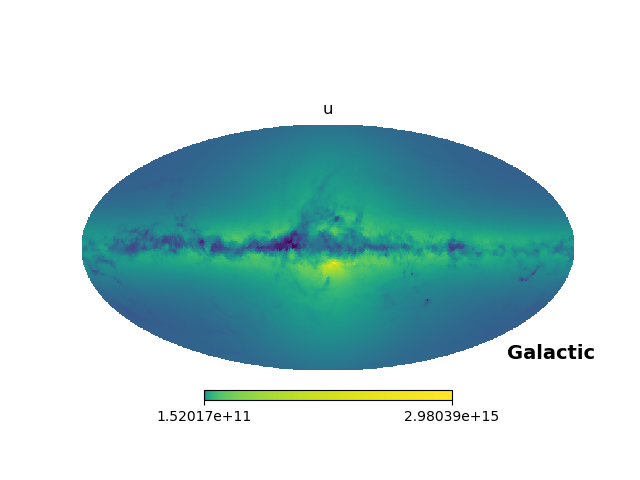

<IPython.core.display.Javascript object>


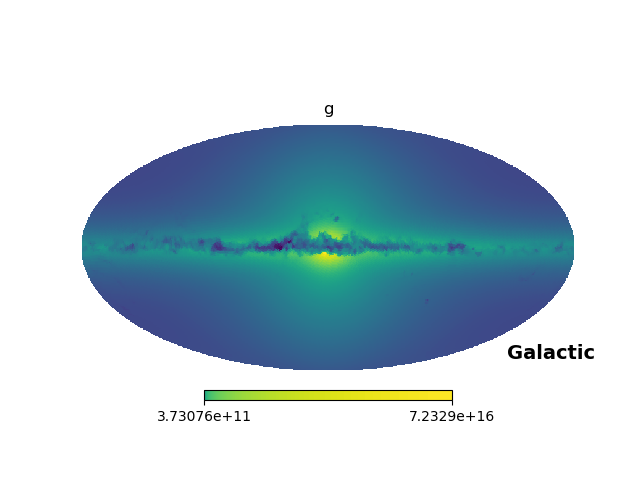

<IPython.core.display.Javascript object>


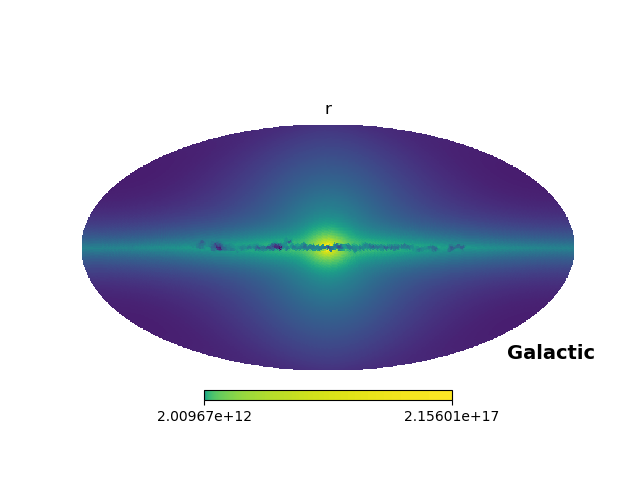

<IPython.core.display.Javascript object>


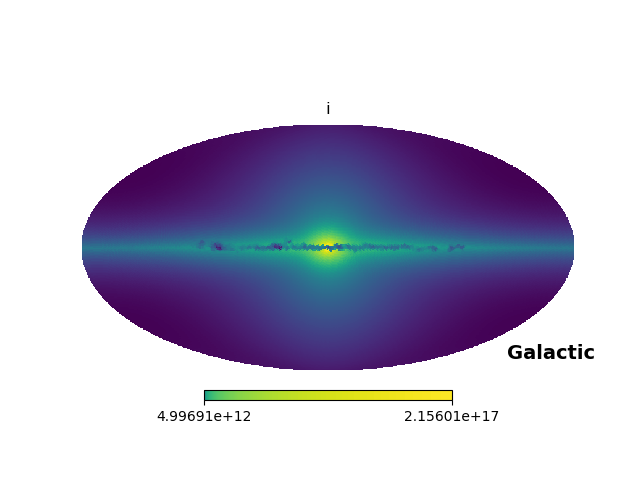

<IPython.core.display.Javascript object>


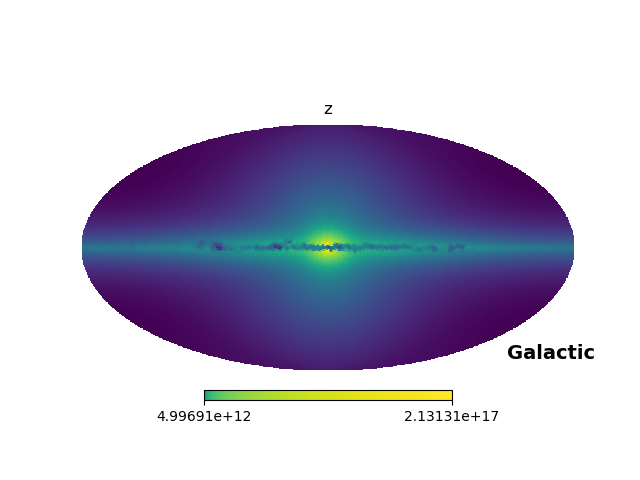

<IPython.core.display.Javascript object>


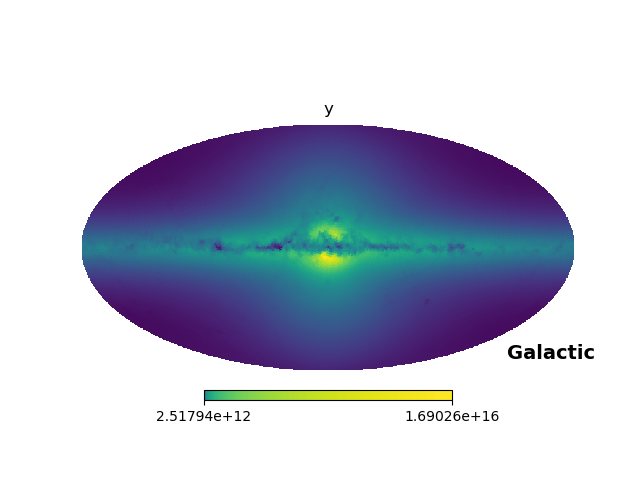

In [70]:
for filt in ['u','g','r','i','z','y']:
    hp.mollview(np.array(integrals[filt]), plt.figure(), coord=['C','G'],hold=True,title=filt,norm='log')

In [71]:
%pdb

Automatic pdb calling has been turned OFF


Now normalize all of them by the total masses

In [75]:
totmass = np.sum([np.sum(integral) for integral in integrals.values()])

In [76]:
totmass

7.724945106547225e+19

In [79]:
normed_maps = {filt:np.array(integral)/totmass for filt,integral in integrals.items()}

<IPython.core.display.Javascript object>


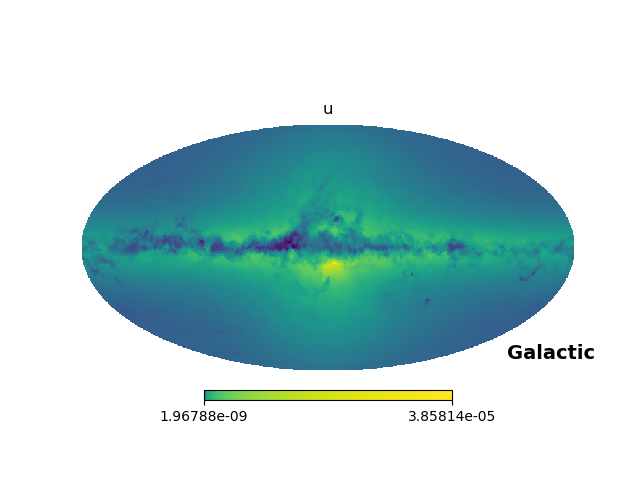

<IPython.core.display.Javascript object>


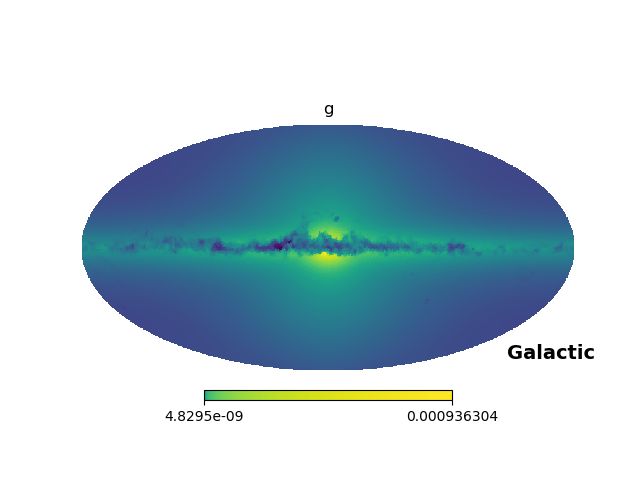

<IPython.core.display.Javascript object>


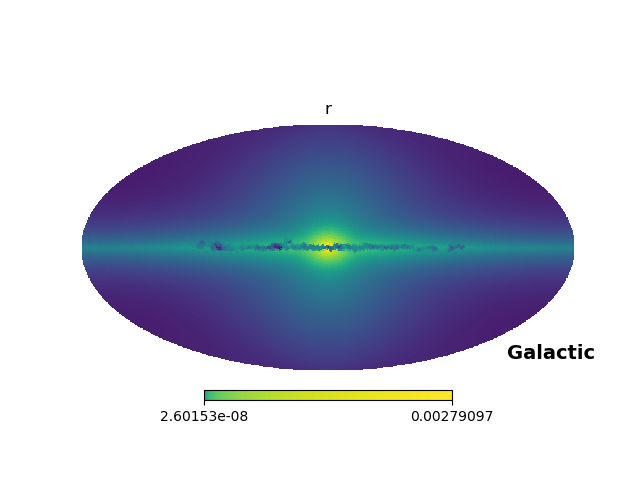

<IPython.core.display.Javascript object>


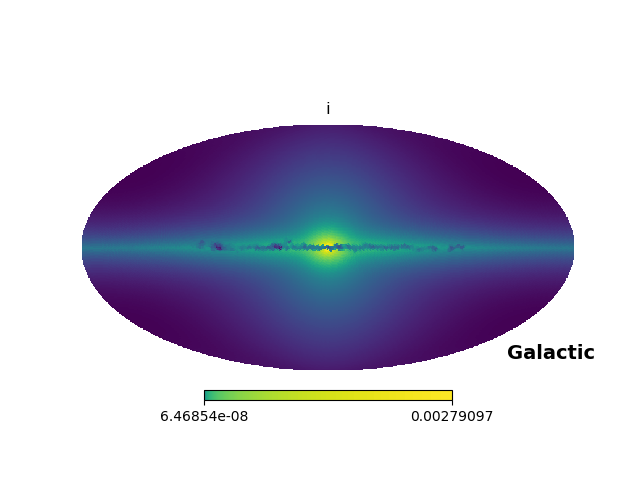

<IPython.core.display.Javascript object>


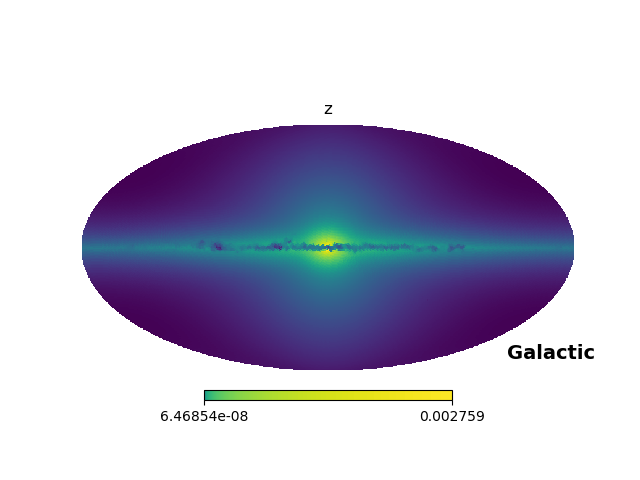

<IPython.core.display.Javascript object>


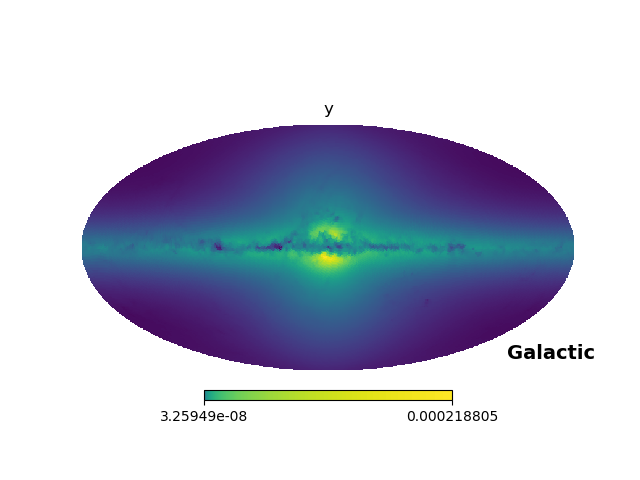

In [84]:
for filt in ['u','g','r','i','z','y']:
    hp.mollview(normed_maps[filt], plt.figure(), coord=['C','G'],hold=True,title=filt,norm='log')

In [85]:
for filt in ['u','g','r','i','z','y']:
    hp.fitsfunc.write_map(f'xrb_priority_map_{filt}.fits',normed_maps[filt],coord='C')

## Construct Probabilistic Sample of XRB locations

For our outburst metric, we'd like a probability-weighted sample of event locations throughout the galaxy.

## Build density grid

In [96]:
grid_coords = np.linspace(-15,15,301) # in kpc
grid_coords

array([-15. , -14.9, -14.8, -14.7, -14.6, -14.5, -14.4, -14.3, -14.2,
       -14.1, -14. , -13.9, -13.8, -13.7, -13.6, -13.5, -13.4, -13.3,
       -13.2, -13.1, -13. , -12.9, -12.8, -12.7, -12.6, -12.5, -12.4,
       -12.3, -12.2, -12.1, -12. , -11.9, -11.8, -11.7, -11.6, -11.5,
       -11.4, -11.3, -11.2, -11.1, -11. , -10.9, -10.8, -10.7, -10.6,
       -10.5, -10.4, -10.3, -10.2, -10.1, -10. ,  -9.9,  -9.8,  -9.7,
        -9.6,  -9.5,  -9.4,  -9.3,  -9.2,  -9.1,  -9. ,  -8.9,  -8.8,
        -8.7,  -8.6,  -8.5,  -8.4,  -8.3,  -8.2,  -8.1,  -8. ,  -7.9,
        -7.8,  -7.7,  -7.6,  -7.5,  -7.4,  -7.3,  -7.2,  -7.1,  -7. ,
        -6.9,  -6.8,  -6.7,  -6.6,  -6.5,  -6.4,  -6.3,  -6.2,  -6.1,
        -6. ,  -5.9,  -5.8,  -5.7,  -5.6,  -5.5,  -5.4,  -5.3,  -5.2,
        -5.1,  -5. ,  -4.9,  -4.8,  -4.7,  -4.6,  -4.5,  -4.4,  -4.3,
        -4.2,  -4.1,  -4. ,  -3.9,  -3.8,  -3.7,  -3.6,  -3.5,  -3.4,
        -3.3,  -3.2,  -3.1,  -3. ,  -2.9,  -2.8,  -2.7,  -2.6,  -2.5,
        -2.4,  -2.3,

In [92]:
# make galactocentric xyz coords for all grid points
gx, gy, gz = np.meshgrid(grid_coords,grid_coords,grid_coords)

In [93]:
gx.shape

(301, 301, 301)

In [94]:
gr = np.sqrt(gx**2. + gy**2.)

In [95]:
gr.shape

(301, 301, 301)

In [138]:
density = rho_bulge(gr,gz) + rho_disk(gr,gz) + rho_sphere(gr,gz)

/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in power
/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in true_divide


In [139]:
density.shape

(301, 301, 301)

In [140]:
density.dtype

dtype('float64')

In [145]:
density.min()

1914.2793186649649

In [146]:
density.max()

inf

In [147]:
winf = np.argwhere(np.isinf(density))

In [148]:
winf

array([[150, 150, 150]])

In [149]:
winf.shape

(1, 3)

In [162]:
density[winf[0,0],winf[0,1],winf[0,2]]

inf

r,z = 0 is infinite, so just replace it with the largest non-infinte value

In [164]:
density[winf[0,0],winf[0,1],winf[0,2]] = np.max(density[np.isfinite(density)])
density[winf[0,0],winf[0,1],winf[0,2]]

130466988212.66547

Now to convert to probabilty.  For ease we will flatten the array; then get the argsort and normalized cumsum.

In [186]:
flat_density = density.flatten()

In [197]:
flat_prob_density = flat_density/np.sum(flat_density)

In [201]:
flat_prob_density.sum(), flat_prob_density.max()

(0.9999999999999981, 0.0033004210631848068)

In [202]:
# reshape back to 3d grid
prob_density_grid = flat_prob_density.reshape(density.shape)

In [203]:
#check that the galactic center is near our max probability
prob_density_grid[150,150,150]

0.0033004210631848068

### Rejection sample the grid

Now we will draw xyz voxels at random with replacement, and use numpy's `rng.choice` to select those elements which are most likely.

(We will later randomize positions relative to the voxel xyz coords)

In [196]:
rng = default_rng()

In [204]:
flat_idx = np.arange(len(flat_prob_density))

In [206]:
sample_voxel_inds = rng.choice(flat_idx,10000000,replace=True,p=flat_prob_density)

In [207]:
sample_voxel_inds

array([13462676, 12713486, 12988601, ..., 13272444, 19058839, 13633943])

In [211]:
flat_prob_density[sample_voxel_inds]

array([3.30880162e-06, 8.86057453e-07, 1.59165808e-06, ...,
       2.14803534e-04, 4.88801984e-09, 1.21872467e-04])

Now we want to convert these flattened indices back to xyz coordinates.

In [213]:
sample_x, sample_y, sample_z = np.unravel_index(sample_voxel_inds,shape=density.shape)